In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from clean_cats_subcats import clean_data
import time
from IPython.core.pylabtools import figsize

In [60]:
import sku_clean

sku_clean

<module 'sku_clean' from 'C:\\Users\\mlentini\\OneDrive - Edmund Optics, Inc\\Documents\\Data Projects\\Projects for Gregg\\Compitor Pricing\\sku_clean.py'>

In [111]:
df = pd.read_csv('specs_prices.csv')
df.head()

,sku,brand,category,subcategory,spec,value,price
0,NDUV509B,Thorlabs,filters,neutral-density,Surface Quality,40-20 scratch-dig,38.82
1,NDUV509B,Thorlabs,filters,neutral-density,Optical Density,0.9,38.82
2,NDUV509B,Thorlabs,filters,neutral-density,Transmittance,13%,38.82
3,NDUV509B,Thorlabs,filters,neutral-density,Substrate,UV Fused Silica,38.82
4,NDUV509B,Thorlabs,filters,neutral-density,Thickness Tolerance,±0.1 mm,38.82


In [62]:
df['subcategory'].nunique()

46

## Preprocessing Data

In [133]:
def sku_clean(df):
    import re
    
    df = df[~df[['sku', 'brand', 'category', 'subcategory', 'spec']].duplicated()]
    df = df.pivot(['sku', 'brand', 'category', 'subcategory', 'price'], columns='spec', values='value').reset_index()
    df.set_index(['sku', 'brand', 'category', 'subcategory', 'price'], inplace=True)
    
    # replace lambda (e.g., 632nm) or '?' with 1
    df = df.replace({'?':1.})

    # searches for floats and returns them if found, else returns whatever was previously there. Return list of floats if more than one supplied
    ranges = [x for x in df.columns if 'Range' in x]
    df[ranges] = df[ranges].applymap(
        lambda x: np.nan if pd.isna(x) 
        else x if isinstance(x, float)
        else x if len([float(i) for i in x.split() if i.replace('.', '', 1).isdigit()]) == 0
        else [float(i) for i in x.split() if i.replace('.', '', 1).isdigit()][0] if len([float(i) for i in x.split() if i.replace('.', '', 1).isdigit()]) == 1
        else [float(i) for i in x.split() if i.replace('.', '', 1).isdigit()]
    )
                    
    # all other columns extract numerical, no lists, otherwise leave as categorical
    not_ranges = [x for x in df.columns if x not in ranges]
    not_ranges = [x for x in not_ranges if x != 'Substrate']
    df[not_ranges] = df[not_ranges].applymap(
        lambda x: np.nan if pd.isna(x)
        else x if isinstance(x, float)
        else x if len(re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)) == 0
        else float(re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)[0]) 
    )

    # infer datatype
    df = df.sort_index(axis=1) # order columns alphebetically
    df.reset_index(inplace=True)
    df = df.infer_objects()
    df = df[~df['sku'].duplicated()]
    df.reset_index(inplace=True, drop=True)
    
    return df

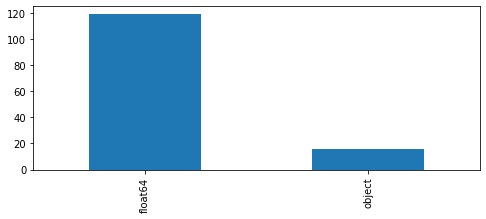

In [134]:
df = pd.read_csv('specs_prices.csv')
df = sku_clean(df)
plt.figure(figsize(8, 3))
df.dtypes.value_counts().plot(kind='bar')
plt.show()

In [122]:
df.head()

spec,sku,brand,category,subcategory,price,?/2 Wave Voltage,?/4 Wave Voltage,Abbe Number,Abbe Number Tolerance,Air Spacing,...,Tuning Range,Wavelength Range,Wedge,Wedge Tolerance,Weight,Width,Width Tolerance,Working Distance,Working Distance Tolerance,f-Number
0,#01-307,Edmund Optics,gratings,transmission,23.0,NaN,NaN,NaN,NaN,NaN,...,NaN,"[400.0, 700.0]",NaN,NaN,NaN,50.8,NaN,NaN,NaN,NaN
1,#02-075,Edmund Optics,windows,windows,12.0,NaN,NaN,NaN,NaN,NaN,...,NaN,"[350.0, 2000.0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#02-105,Edmund Optics,windows,windows,12.5,NaN,NaN,NaN,NaN,NaN,...,NaN,"[350.0, 2000.0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,#02-146,Edmund Optics,windows,diffusers,43.0,NaN,NaN,NaN,NaN,NaN,...,NaN,"[350.0, 2000.0]",NaN,NaN,NaN,127.0,NaN,NaN,NaN,NaN
4,#02-147,Edmund Optics,windows,diffusers,45.0,NaN,NaN,NaN,NaN,NaN,...,NaN,"[350.0, 2000.0]",NaN,NaN,NaN,203.0,NaN,NaN,NaN,NaN


## Feature Importance 
Rank features and assign weights to be used in distance metric

In [237]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    #print('Remaining variables:')
    #print(X.columns[variables])
    return X.iloc[:, variables]

def feature_importance(df, subcategory='dielectric'):
    """
    Feature importances with desicion tree
    """
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.preprocessing import LabelEncoder
    from sklearn.inspection import permutation_importance

    clf = DecisionTreeRegressor(random_state=0)  # model

    data = df[df['subcategory'] == subcategory] # select subcategory
    #data = data[data['brand'] == brand]
    data = data.set_index(['sku', 'brand', 'category', 'subcategory'])

    # replace nan with numerical nan equivalent
    nan_eqv = 99999.
    data = data.fillna(nan_eqv)

    # break data into data vs target variable
    X = data.drop('price', axis=1)
    y = data['price']

    # split data based on datatype, encode and recombine
    num = X.select_dtypes(include='float64')
    cat = X.select_dtypes(include='object').astype(str)

    # encode categorical/list data
    le = LabelEncoder()
    cat = pd.DataFrame(
        le.fit_transform(cat.to_numpy().ravel())\
        .reshape(cat.shape),
        columns=cat.columns
    )

    # recombine categorical/list and numerical data
    cat.index = X.index
    X = pd.concat([num, cat], axis=1).sort_index(axis=1)
    
    # remove collinearity from dataset
    #X = calculate_vif_(X, thresh=5.0)
    #features = X.columns

    # fit model and check how well it fits
    model = clf.fit(X,y)
    print('Decision Tree Accuracy:', model.score(X,y))
    
    
    imp = permutation_importance(clf, X, y, n_repeats=10, random_state=0) # permutate and take average
    
    return imp.importances_mean, imp.importances_std 

## Removing Collinearity 
Collinearity can affect feature importance seletion, since permuting a value may not affect the model score if it is highly collinear with another value, and therefore may be erroneously deemed unimportant

C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


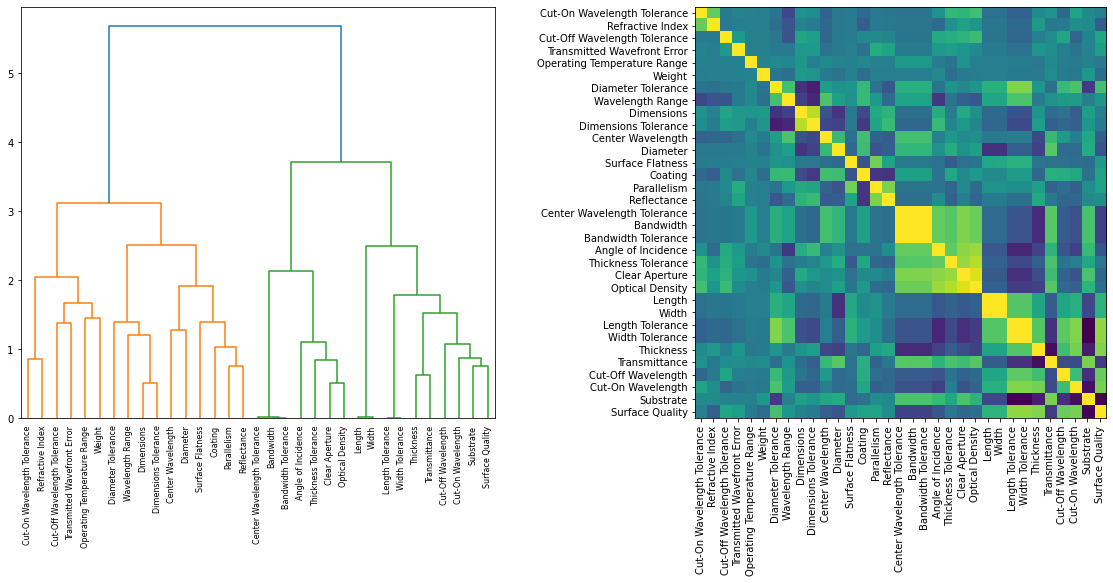

In [158]:
data = df[df['subcategory'] == 'dielectric'] # select subcategory
#data = data[data['brand'] == brand]
data = data.set_index(['sku', 'brand', 'category', 'subcategory'])

# replace nan with numerical nan equivalent
nan_eqv = 99999.
data = data.fillna(nan_eqv)

# break data into data vs target variable
X = data.drop('price', axis=1)
y = data['price']

# split data based on datatype, encode and recombine
num = X.select_dtypes(include='float64')
cat = X.select_dtypes(include='object').astype(str)

# encode categorical/list data
le = LabelEncoder()
cat = pd.DataFrame(
    le.fit_transform(cat.to_numpy().ravel())\
    .reshape(cat.shape),
    columns=cat.columns
)

# recombine categorical/list and numerical data
cat.index = X.index
X = pd.concat([num, cat], axis=1).sort_index(axis=1)


from scipy import stats
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
corr = stats.spearmanr(X.loc[:, X.var() != 0]).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
feature_names = X.loc[:, X.var() != 0].columns
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(distance_matrix)
dendro = hierarchy.dendrogram(
    dist_linkage, labels=feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

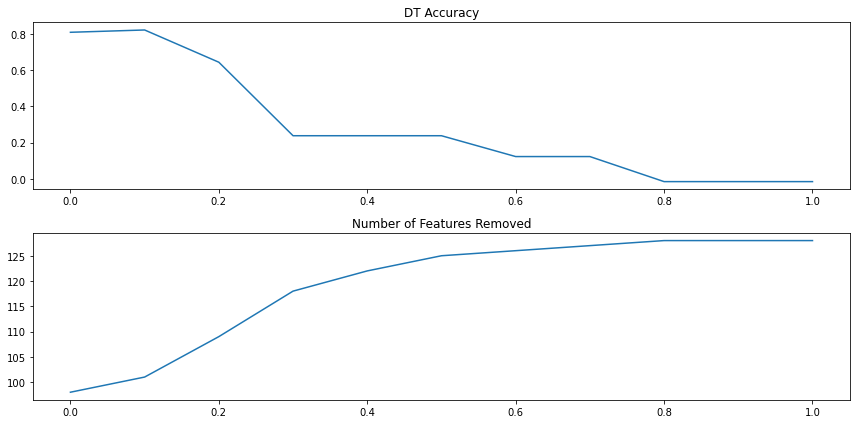

In [239]:
scores = []
removed = []
for i in np.linspace(0, 5, 11):
    cluster_ids = hierarchy.fcluster(dist_linkage, i, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

    clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)


    X_train_sel = X_train.iloc[:, selected_features]
    X_test_sel = X_test.iloc[:, selected_features]

    from sklearn.tree import DecisionTreeRegressor
    clf_sel = DecisionTreeRegressor(random_state=0)
    X_sel = X.iloc[:, selected_features].to_numpy()
    clf_sel.fit(X_train_sel, y_train.to_numpy())
    
    scores.append(clf_sel.score(X_test_sel, y_test))
    removed.append(len(X.columns) - len(selected_features))
    
    
fig, ax = plt.subplots(2, figsize=(12, 6))
ax[0].plot(np.linspace(0, 1, 11), scores)
ax[0].set_title('DT Accuracy')
ax[1].plot(np.linspace(0, 1, 11), removed)
ax[1].set_title('Number of Features Removed')

fig.tight_layout()
plt.show()

In [236]:
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

cluster_ids = hierarchy.fcluster(dist_linkage, 0, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)


X_train_sel = X_train.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

from sklearn.tree import DecisionTreeRegressor
clf_sel = DecisionTreeRegressor(random_state=0)
X_sel = X.iloc[:, selected_features].to_numpy()
clf_sel.fit(X_train_sel, y_train.to_numpy())


print("Number of features removed:", len(X.columns) - len(selected_features))
print(
    "Accuracy on test data with features removed: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    )
)

clf = DecisionTreeRegressor(random_state=0)
clf.fit(X_train, y_train)
print(
    "Accuracy on test data with no features removed: {:.2f}".format(
        clf.score(X_test, y_test)
    )
)

Number of features removed: 98
Accuracy on test data with features removed: 0.81
Accuracy on test data with no features removed: 0.97


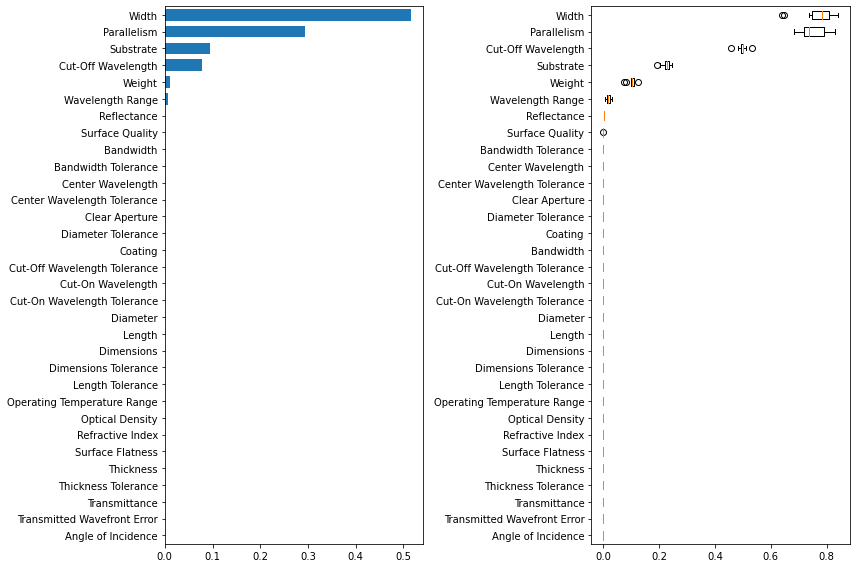

In [234]:
from sklearn.inspection import permutation_importance
clf = DecisionTreeRegressor(random_state=0)
X_sel = X.iloc[:, selected_features].to_numpy()
clf.fit(X_sel, y.to_numpy())


result = permutation_importance(clf, X_sel, y, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=feature_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

Decision Tree Accuracy: 0.9972937249249795


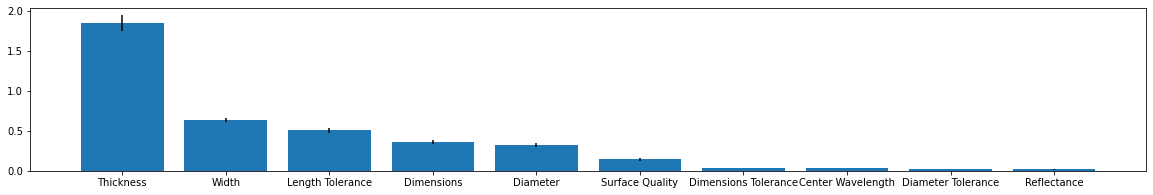

In [238]:
subcat = 'dielectric'
brand = 'Knight Optical'
data = df[df['subcategory'] == subcat]

# get feature importances
drop = ['sku', 'brand', 'category', 'subcategory', 'price']
importance = pd.DataFrame(data.drop(drop, axis=1).columns)

mean_import, std_import = feature_importance(df, subcategory=subcat)
#importance = pd.DataFrame(features)
importance['importance'] = mean_import
importance['error'] = std_import

# sort importances and plot
importance = importance.sort_values(by='importance', ascending=False)

i = 10
plt.figure(figsize(20, 3))
plt.bar(importance.head(i)['spec'], importance.head(i)['importance'], yerr=importance.head(i)['error'])
plt.show()

## Distance Metric

#
When comparing one complete feature set to the same set in another part, penalize missing values. Penalization should be in inverse proportion to the number of features in the complete feature set.

Give points for categorical matches. Mesaure distance between numberical values and reward closeness.

4 Things: Categorical Similarity (e.g., Jiccard), Numerical (e.g., Euclidean), Missing Values, Lists or Ranges

Distance should map roughly to 0 and 1. 

More harshly penalize mismatches or descrepencies between more important features 

In [7]:
def number_of_features(x,y):
    """
    Count distinct number of features in the complete features sets of x and y
    """
    return sum(~pd.isna(x) | ~pd.isna(y))

def missing_values(x,y):
    """
    Count the number values missing from the complete features sets of x and y
    """
    missing_values = (mean_import[pd.isna(x) != pd.isna(y)]).sum()#(pd.isna(x) != pd.isna(y)).sum()

    return missing_values/number_of_features(x,y)

def list_overlap(x,y):
    """
    If numerical overlap between two lists is perfect return 0, if there is not overlap return 1
    Remove missing data before use
    """
    # if both features are lists compare overlap
    isList = np.array([isinstance(i, list) for i in x]) & np.array([isinstance(i, list) for i in y])
    imp = mean_import[isList]
    k = 0
    relative_overlap = []
    for i,j in zip(x[isList], y[isList]):
        if (min(i) > max(j)) | (min(j) > max(i)):
            relative_overlap.append(imp[k])
        else:
            overlap = abs(max(i[0],j[0]) - min(i[-1],j[-1]))
            total_range = abs(min(i[0],j[0]) - max(i[-1],j[-1]))
            
            # normalized overlap where smaller (shorter distance) is better
            if total_range != 0:  
                relative_overlap.append(1 - imp[k]*overlap/total_range)
            else:
                relative_overlap.append(imp[k])
        k += 1
        
    if isList.sum() > 0:
        return sum(relative_overlap)#/isList.sum()
    return 0

def num_error(x,y):
    """
    Error between numerical values
    """
    isNum = np.array([isinstance(i, float) for i in x]) & np.array([isinstance(i, float) for i in y])
    notNan = ~pd.isna(x) & ~pd.isna(y)
    imp = mean_import[isNum & notNan]
                     
    num_err = 0
    k = 0                
    for i,j in zip(x[isNum & notNan], y[isNum & notNan]):  
        if i+j != 0:
            num_err += abs((i-j)/(i+j))*imp[k]
        else:
            pass
        k += 1
    
    if isNum.sum() > 0:
        return num_err#/isNum.sum()
    return 0

def cat_error(x,y):
    """
    Categorical error
    """
    isStr = np.array([isinstance(i, str) for i in x]) & np.array([isinstance(i, str) for i in y])

    # count the number of mismatches
    if isStr.sum() > 0:
        return ((x[isStr] != y[isStr])*mean_import[isStr]).sum()/isStr.sum()
    return 0

def incompatible_error(x,y):
    """
    Add distance for comparisons between incompatible types
    """

def sku_distance(x,y):
    i, j = int(x[0]), int(y[0])
    x = df.iloc[i].to_numpy()[5:]
    y = df.iloc[j].to_numpy()[5:]
    
    return np.linalg.norm([missing_values(x,y), list_overlap(x,y), num_error(x,y), cat_error(x,y)])
    return missing_values(x,y) + list_overlap(x,y) + num_error(x,y) + cat_error(x,y)

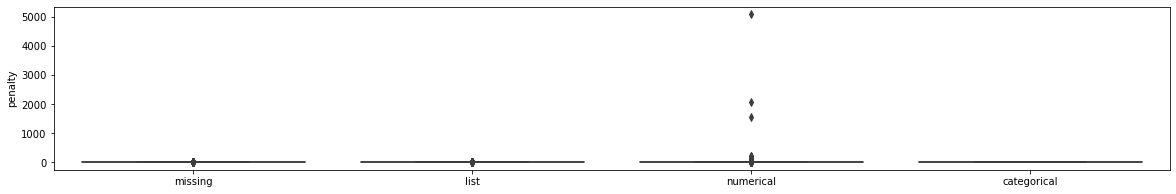

In [625]:
test_result = []
for i in range(len(df)):    
    x = [int(np.random.uniform(low=0, high=len(df)))]
    y = [int(np.random.uniform(low=0, high=len(df)))]
    
    i, j = int(x[0]), int(y[0])
    x = df.iloc[i].to_numpy()[5:]
    y = df.iloc[j].to_numpy()[5:]
    
    test_result = np.concatenate([
        test_result,
        [
            missing_values(x,y),
            list_overlap(x,y),
            num_error(x,y),
            cat_error(x,y)
        ]
    ])
    
fig, ax = plt.subplots()
sns.boxplot(data=test_result.reshape(-1,4), ax=ax)
ax.set_xticklabels(['missing', 'list', 'numerical', 'categorical'])
ax.set_ylabel('penalty')
plt.show()

## Nearest Neighbors using SKU Distance

In [8]:
# return closest neighber
from sklearn.neighbors import NearestNeighbors
def find_closest_eo_sku(df, brand='Knight Optical', subcategory='dielectric'):
    """
    Using model trained on EO data, find eo parts closest to competitor parts
    """  
    # get data
    data = df[df['subcategory'] == subcategory]

    # train on Edmund SKUs
    X_train = data[data['brand'] == 'Edmund Optics'].index.to_numpy().reshape(-1, 1) # use index allow distance metric to operate over categorical vars

    # fit data using made-up sku_distance metric
    neigh = NearestNeighbors(n_neighbors=1, metric=sku_distance)
    neigh.fit(X_train)
 
    X_test = data[data['brand'] == brand].index.to_numpy().reshape(-1,1)
    
    start_time = time.time()
    results = neigh.kneighbors(X_test, n_neighbors=1, return_distance=True)

    elapsed_time = time.time() - start_time
    print(f"Runtime: {elapsed_time:.3f} seconds")

    # evaluate results
    train = data[data['brand'] == 'Edmund Optics'].copy()
    test = data[data['brand'] == brand].copy()

    #test['nbr'] = results[1]
    test['dist'] = results[0]
    test['nbr'] = train.iloc[results[1].ravel()]['sku'].values
    test['nbr brand'] = train.iloc[results[1].ravel()]['brand'].values
    test['nbr price'] = train.iloc[results[1].ravel()]['price'].values
    test['price_diff'] = test['nbr price'] - test['price']
    test['reg_price_diff'] = (test['nbr price'] - test['price'])/(test['nbr price'] + test['price'])
    
    return test[['brand', 'nbr brand', 'sku', 'nbr', 'price', 'nbr price', 'dist', 'price_diff', 'reg_price_diff']]

In [55]:
# test example
result = pd.DataFrame([])
subcat = 'dielectric'
brand = 'Thorlabs'

mean_import, std_import = feature_importance(df, subcategory=subcat)
mean_import = mean_import/mean_import.sum() + 1 # normalize importance, add 1 so that no feature is left out
#mean_import = np.ones(len(mean_import))
result = find_closest_eo_sku(df, brand=brand, subcategory=subcat)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


dropping 'Surface Quality' at index: 108
dropping 'Dimensions' at index: 39
dropping 'Width Tolerance' at index: 124
dropping 'Length' at index: 58
dropping 'Bandwidth Tolerance' at index: 13
dropping 'Bandwidth' at index: 12
dropping 'Length Tolerance' at index: 56
dropping 'Optical Density' at index: 69
dropping 'Parallelism' at index: 72
dropping 'Dimensions Tolerance' at index: 37
dropping 'Center Wavelength Tolerance' at index: 18
dropping 'Cut-On Wavelength' at index: 28
dropping 'Clear Aperture' at index: 19
dropping 'Thickness' at index: 98
dropping 'Diameter' at index: 32
Remaining variables:
Index(['?/2 Wave Voltage', '?/4 Wave Voltage', 'Abbe Number',
       'Abbe Number Tolerance', 'Air Spacing', 'Angle', 'Angle Tolerance',
       'Angle of Incidence', 'Angle of Incidence Tolerance', 'Apex Angle',
       ...
       'Transmitted Wavefront Error', 'Tuning Range', 'Wavelength Range',
       'Wedge', 'Wedge Tolerance', 'Weight', 'Width', 'Working Distance',
       'Working Dist

IndexError: boolean index did not match indexed array along dimension 0; dimension is 115 but corresponding boolean dimension is 130

In [312]:
[x for x in df.loc[df['subcategory'] == subcat, 'brand'].unique() if x != 'Edmund Optics']

['Knight Optical']

## Find Matches

In [240]:
completed_subcat = []

In [241]:
# find nearest EO SKU for every competitor SKU
# batch according to subcategory, loop through brands
result = pd.DataFrame([])

i = 1
for subcat in [x for x in df['subcategory'].unique() if x not in completed_subcat]:
    
    # find matches
    mean_import, std_import = feature_importance(df, subcategory=subcat)
    mean_import = mean_import/mean_import.sum() + 1
    for brand in [x for x in df.loc[df['subcategory'] == subcat, 'brand'].unique() if x != 'Edmund Optics']:
        result = pd.concat([result, find_closest_eo_sku(df, brand=brand, subcategory=subcat)], axis=0)
        
    # save work and update progress
    result.to_csv('matches.csv')
    completed_subcat.append(subcat)
    i += 1
    print(str(round(100*i/df['subcategory'].nunique(),1)) + '% Completed')

Decision Tree Accuracy: 0.9986715673375629
Runtime: 4.843 seconds
Runtime: 6.097 seconds
Runtime: 0.307 seconds
Runtime: 1.940 seconds
4.3% Completed
Decision Tree Accuracy: 0.9904365394148947
Runtime: 42.555 seconds
Runtime: 18.543 seconds
Runtime: 93.154 seconds
Runtime: 36.757 seconds
Runtime: 36.996 seconds
6.5% Completed
Decision Tree Accuracy: 0.5049367640442448
Runtime: 81.636 seconds
Runtime: 7.401 seconds
Runtime: 14.029 seconds
Runtime: 15.726 seconds
8.7% Completed
Decision Tree Accuracy: 0.9969354836527242
Runtime: 190.266 seconds
Runtime: 310.480 seconds
Runtime: 147.356 seconds
Runtime: 39.697 seconds
Runtime: 193.480 seconds
10.9% Completed
Decision Tree Accuracy: 0.9999839313094262
Runtime: 0.111 seconds
Runtime: 0.375 seconds
Runtime: 0.278 seconds
13.0% Completed
Decision Tree Accuracy: 0.9235129666766453
Runtime: 43.145 seconds
Runtime: 63.627 seconds
Runtime: 80.054 seconds
Runtime: 12.947 seconds
Runtime: 29.333 seconds
15.2% Completed
Decision Tree Accuracy: 0.999

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

## 
The relationship between distance (which not based at all on price, but specs) and price difference should be positivley linearly correlated. I.e., as distance increases we would also expect price difference to increase. The algorithm merely finds the closest match, but if there is no close match the match will be bad, and correpsondingly, we expect that the price differences should increase on average.

(0.6521387279584545, 0.05697544924791682)


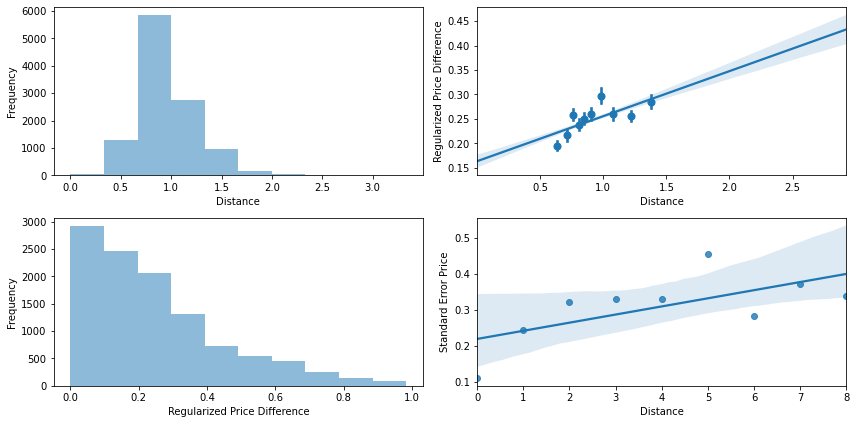

In [252]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
result = pd.read_csv('matches.csv')
result = result[result['brand'] != 'Edmund Optics']

import seaborn as sns
ax[0,0].hist(result['dist'], alpha=0.5)
ax[1,0].hist(np.abs(result['reg_price_diff']), alpha=0.5)
sns.regplot(x=result['dist'], y=np.abs(result['reg_price_diff']), ax=ax[0,1],  x_bins=10)

#ax[1,1].scatter(x=result['dist'], y=np.abs(result['reg_price_diff']), alpha=0.5)
bins = 10
std_groups = result.groupby(pd.cut(result['dist'], bins))['reg_price_diff'].std()#.plot(ax=ax[1,1])
sns.regplot(x=np.arange(len(std_groups)), y=std_groups.values, ax=ax[1,1])

from scipy import stats
print(stats.pearsonr(np.arange(len(std_groups.dropna())), std_groups.dropna().values))


ax[0,0].set_xlabel('Distance')
ax[0,0].set_ylabel('Frequency')

ax[1,0].set_xlabel('Regularized Price Difference')
ax[1,0].set_ylabel('Frequency')

ax[0,1].set_xlabel('Distance')
ax[0,1].set_ylabel('Regularized Price Difference')

ax[1,1].set_xlabel('Distance')
ax[1,1].set_ylabel('Standard Error Price')

plt.tight_layout()
plt.show()

In [655]:
data = df[df['subcategory'] == 'dielectric']

a = np.abs(result['reg_price_diff']) <= 0.10
b = np.abs(result['dist']) <= 1
q = result.loc[a&b,:].sort_values(['dist', 'price_diff'])

i = 4
a = data['sku'] == q.iloc[i]['sku']
b = data['sku'] == q.iloc[i]['nbr']
print('distance:', q.iloc[i]['dist'])
print('regular price difference:', q.iloc[i]['reg_price_diff'])

x = data[a|b]

x.loc[:, ~x.isna().all(axis=0)]

distance: 0.6379855639778564
regular price difference: 0.08005082592121984


spec,sku,brand,category,subcategory,price,Angle of Incidence,Bandwidth,Bandwidth Tolerance,Center Wavelength,Center Wavelength Tolerance,Clear Aperture,Diameter,Diameter Tolerance,Optical Density,Surface Quality,Thickness,Thickness Tolerance,Transmittance
6195,#65-662,Edmund Optics,filters,dielectric,102.00,0.0,10.0,2.0,766.0,2.0,9.0,12.5,0.0,3.0,80.0,7.5,0.1,50.0
10634,620DIB12,Knight Optical,filters,dielectric,86.88,NaN,NaN,NaN,620.0,NaN,NaN,12.5,NaN,NaN,80.0,6.1,0.2,50.0


In [575]:
q.sort_values('dist').reset_index(drop=True).head()

spec,brand,nbr brand,sku,nbr,price,nbr price,dist,price_diff,reg_price_diff
0,Knight Optical,Edmund Optics,590DIB12,#65-655,86.88,92.0,0.557985,5.12,0.028623
1,Knight Optical,Edmund Optics,589DIN12,#65-654,103.56,92.0,0.557985,-11.56,-0.059112
2,Knight Optical,Edmund Optics,490FDL12,#64-441,25.65,92.0,0.571979,66.35,0.563961
3,Knight Optical,Edmund Optics,480FDL12,#64-438,25.65,48.5,0.571979,22.85,0.308159
4,Knight Optical,Edmund Optics,470FDS50,#64-438,47.96,48.5,0.571979,0.54,0.005598


In [504]:
q['brand'].value_counts()

Knight Optical    300
Name: brand, dtype: int64

In [577]:
q['nbr'].value_counts().head(10)

#86-312    44
#64-455    26
#67-779    20
#47-285    14
#64-467    12
#64-450    11
#67-057     7
#64-438     7
#46-388     7
#15-218     7
Name: nbr, dtype: int64

In [319]:
np.linspace(data['dist'].min(), data['dist'].max(), 5)[1:-1]

array([0.8329118 , 1.6658236 , 2.49873539])

## Determine Cut-Off Distance for Matches
Tails for KDE get fatter (more frequent large descrepencies in price are observed) for parts with with larger distances. This also confirms our suspicion that the standard deviation on price differences increases (becomes more random and spread out) for larger distances.

Distance cut-off s.t. reg price diff <= 0.1: 0.95
Max dist: 0.666820008084556
Match: 
 False    9772
True     1360
Name: match, dtype: int64
Average Reg Price Diff Match: 8.611%
Max dist: 1.3330268042659605
Match: 
 True     9941
False    1191
Name: match, dtype: int64
Average Reg Price Diff Match: 2.227%
Max dist: 1.999233600447365
Match: 
 True     11056
False       76
Name: match, dtype: int64
Average Reg Price Diff Match: 2.013%


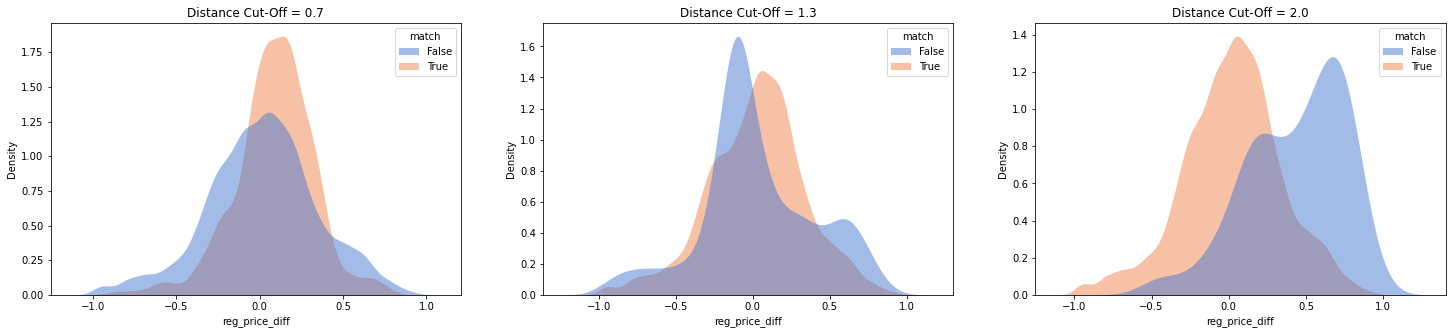

In [424]:
data = pd.read_csv('matches.csv')
data = data[data['brand'] != 'Edmund Optics']
dist_cut = data.loc[
    (data['brand'] != 'Edmund Optics') &
    (data['reg_price_diff'] <= 0.1),
    'dist'
].mean()

print("Distance cut-off s.t. reg price diff <= 0.1:", np.round(dist_cut,2))

data_cut = data.loc[
    data['dist'] <= dist_cut,
    'reg_price_diff'
]

fig, ax = plt.subplots(1,3, figsize=(25, 5))

j = 0
for i in np.linspace(data['dist'].min(), data['dist'].max(), 6)[1:-2]:
    data['match'] = data['dist'] <= i # dist cut
    
    # plot kernel density estimators
    sns.kdeplot(
       data=data, x="reg_price_diff", hue="match",
       fill=True, common_norm=False, palette="muted",
       alpha=.5, linewidth=0, ax=ax[j]
    )
    
    # plot test
    #ymax = ax[j].get_ylim()[1]
    
    #ax[j].set_ylim(0, 9)
    #ax[j].set_xlim(-1.3, 1.3)
    ax[j].set_title("Distance Cut-Off = {}".format(round(i, 1)))
    j += 1
    
    print('Max dist:', i)
    print('Match: \n', data['match'].value_counts())
    print('Average Reg Price Diff Match:', str(np.round(100*data.loc[data['match'] == True, 'reg_price_diff'].mean(), 3)) + '%')

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


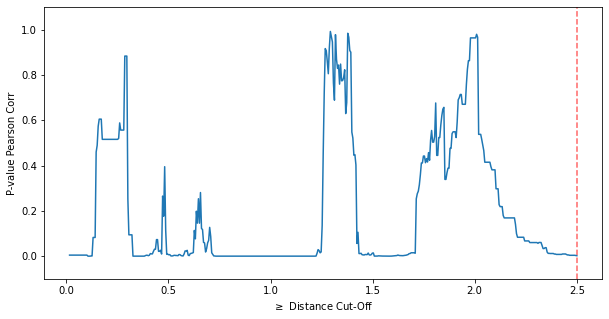

0.12583299086591943
2.5


In [428]:
corr = []
cuts = np.linspace(data['dist'].min(), 2.5, 500)[1:]
for i in cuts:
    data['match'] = data['dist'] >= i
    
    a = data[data['match'] == False]
    a = a[
        (~a['dist'].isna()) &
        (-a['reg_price_diff'].isna())
    ]
    corr.append(stats.pearsonr(a['dist'], a['reg_price_diff'])[1])
    
# max cut for significance
max_cut = cuts[np.array(corr) <= 0.01].max()

vec = np.array(corr) <= 0.01
v0 = vec[0]
i = 0
change_pt = []
for v in vec[1:]:
    if v0 != v:
        change_pt.append(i)
        v0 = v
    i += 1


plt.plot(cuts, corr)
plt.vlines(max_cut, ymin=-0.1, ymax=1.1, color='r', alpha=0.6, linestyle='--')
plt.ylim(-0.1, 1.1)

plt.xlabel('$\geq$ Distance Cut-Off')
plt.ylabel('P-value Pearson Corr')
plt.show()

print(cuts[change_pt[1]])
print(max_cut)

In [431]:
data[data['dist'] <= 0.85].to_csv('matching_parts.csv')

In [15]:
data = pd.read_csv('matching_parts.csv', index_col=[0])
data = data[['sku', 'nbr', 'dist']]
data.head()

,sku,nbr,dist
66,G1200TU26.7CB,#85-290,0.648902
67,G1200TU26.7GB,#85-295,0.648902
68,G1200TU26.7JB,#85-295,0.660653
69,G1200TU26.7MB,#85-300,0.648902
70,G1200TU36.9CB,#85-290,0.668332


## Merge Data for Power BI Report

In [93]:
df = pd.read_csv('prices_samples.csv')
df['date']= pd.to_datetime(df['date']).dt.date

data = pd.read_csv('matching_parts.csv', index_col=[0])
data = data[['sku', 'nbr', 'dist']]

print(len(data))
data = df.merge(data, left_on='sku', right_on='sku')
print(len(data))
data.rename(columns={'price':'comp_price', 'sku':'comp_sku', 'nbr':'eo_sku'}, inplace=True)
data = data.merge(df[['sku', 'currency', 'date', 'price']], left_on=['eo_sku', 'currency', 'date'], right_on=['sku', 'currency', 'date'])
data.rename(columns={'price':'eo_price'}, inplace=True)
data.drop('sku', axis=1, inplace=True)

data.head()

5084
311


,brand,comp_sku,comp_price,currency,category,subcategory,date,eo_sku,dist,eo_price
0,EKSMA Optics,BBO-1021-02H,695.00,EUR,nlcrystals,nlcrystals_nlcrystals,2021-11-10,#11-169,0.758624,599.00
1,EKSMA Optics,BBO-1021-02H,593.39,GBP,nlcrystals,nlcrystals_nlcrystals,2021-11-10,#11-169,0.758624,509.15
2,EKSMA Optics,BBO-0718-04H,567.78,GBP,nlcrystals,nlcrystals_nlcrystals,2021-11-10,#11-169,0.746527,509.15
3,Thorlabs,AL1210M-B,165.56,GBP,lenses,lenses_aspheric,2021-11-10,#33-264,0.642257,51.85
4,Thorlabs,AC508-100-A,102.30,EUR,lenses,lenses_achromatic,2021-11-10,#87-192,0.824642,335.00


In [116]:
df.loc[df['spec'] == 'Substrate', 'value'].value_counts()

N-BK7                     3888
BK7                       2954
UV Fused Silica           1698
Fused Silica               972
Borofloat                  657
                          ... 
BAK4                         1
N-BK7, N-FK5, SF2, SF5       1
N-SF6HT, SF10                1
N-BK7, N-LASF45              1
Colour Glass, RG830          1
Name: value, Length: 291, dtype: int64